In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import os
import re
import cv2
from time import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [2]:
results_dir = '/u/jskang/project/tracking/darknet/parse/parsed'
data_dir = '/u/jskang/project/tracking/orig_data'

In [200]:
def scale_box(df, im):
    predict_im_size = 832.
    df = df.copy(deep = True)
    df.columns = ['prob', 'x', 'y', 'w', 'h']

    # Vertical is stretched as the same as width, rest is filled with blank space
    im_height, im_width, _ = im.shape
    width_scale = im_width / predict_im_size
    height_scale = im_height / predict_im_size
    scale_diff = (predict_im_size - (im_height / width_scale)) / 2.
    
    df.iloc[:,[1,3]] = np.round(df.iloc[:,[1,3]] * width_scale)
    df.iloc[:,[2,4]] = np.round((df.iloc[:,[2,4]] - scale_diff) * width_scale)
    df.iloc[:,3] = df.iloc[:,3] - df.iloc[:,1]
    df.iloc[:,4] = df.iloc[:,4] - df.iloc[:,2]
    
    return df

def scale_box_new(df, im):
    predict_im_size = 832.
    df = df.copy(deep = True)
    df.apply(pd.to_numeric, errors='ignore')
    df.columns = ['x', 'y', 'w', 'h', 'frame_number']

    # Vertical is stretched as the same as width, rest is filled with blank space
    im_height, im_width, _ = im.shape
    width_scale = im_width / predict_im_size
    height_scale = im_height / predict_im_size
    scale_diff = (predict_im_size - (im_height / width_scale)) / 2.

    df.iloc[:,[0,2]] = np.round(df.iloc[:,[0,2]] * width_scale)
    df.iloc[:,[1,3]] = np.round((df.iloc[:,[1,3]] - scale_diff) * width_scale)
    df.iloc[:,2] = df.iloc[:,2] - df.iloc[:,0]
    df.iloc[:,3] = df.iloc[:,3] - df.iloc[:,1]
    
    return df

def ltbr_2_xywh(df):
    df = df.copy(deep=True)
    if len(df.columns) == 5:
        df.columns = ['x', 'y', 'w', 'h', 'frame_number']
    else:
        df.columns = ['x', 'y', 'w', 'h']
    df.w = df.w - df.x
    df.h = df.h - df.y

    return df

def xywh_2_ltbr(df):
    df = df.copy(deep=True)
    if len(df.columns) == 5:
        df.columns = ['x1', 'y1', 'x2', 'y2', 'frame_number']
    else:
        df.columns = ['x1', 'y1', 'x2', 'y2']
    df.x2 = df.x1 + df.x2
    df.y2 = df.y1 + df.y2
    return df

def overlap_area(box1, box2):
    ltbr_box1 = xywh_2_ltbr(box1)
    ltbr_box1 = ltbr_box1.iloc[0]
    ltbr_box2 = xywh_2_ltbr(box2)
    ltbr_box2 = ltbr_box2.iloc[0]
    
    left = np.maximum(ltbr_box1['x1'], ltbr_box2['x1'])
    right = np.minimum(ltbr_box1['x2'], ltbr_box2['x2'])
    top = np.maximum(ltbr_box1['y1'], ltbr_box2['y1'])
    bot = np.minimum(ltbr_box1['y2'], ltbr_box2['y2'])
        
    height = np.maximum(bot - top, 0)
    width = np.maximum(right - left, 0)
    area = height * width
    
    return area

def box_size(box):
    area = box.w * box.h
    return area.as_matrix()

def iou(box1, box2):
    overlap = overlap_area(box1, box2)
    box1_area = box_size(box1)
    box2_area = box_size(box2)
    iou = overlap / (box1_area + box2_area - overlap)
    
    return iou[0]

def overlap_frames(prev, curr, conversion = False, shift_scale = 0.3):
    if conversion is True:
        prev_ltbr = xywh_2_ltbr(prev)
        curr_ltbr = xywh_2_ltbr(curr)

    else:
        prev_ltbr = prev.copy(deep = True)
        curr_ltbr = curr.copy(deep = True)
        
    # Shift based on average position of the boxes
    shift = calculate_shift(curr_ltbr, prev_ltbr)
    scaled_shift = np.array(shift) * shift_scale
    
    # Scale based on average size of the boxes
    # curr_box = box_area_frame(curr)
    # prev_box = box_area_frame(prev)
    # scale = calculate_scale(curr_box, prev_box)
    scale = 1.
    
    result_array = []
    for index, data in prev_ltbr.iterrows():
        left = pick_max(curr_ltbr['x1'], data.x1 / scale - scaled_shift[0] )
        right = pick_min(curr_ltbr['x2'], data.x2  / scale - scaled_shift[0])
        top = pick_max(curr_ltbr['y1'], data.y1 / scale - scaled_shift[1])
        bot = pick_min(curr_ltbr['y2'], data.y2  / scale - scaled_shift[1])
        
        height = pick_max((bot - top), 0)
        width = pick_max((right - left), 0)
        
        result_array = np.append(result_array, height * width)
    result_array = result_array.reshape((prev_ltbr.shape[0], curr_ltbr.shape[0]))
    
    return result_array

def show_image(im):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.] )
    ax.set_axis_off( )
    fig.add_axes(ax)
    
    ax.imshow(im)
    return ax

In [ ]:
# Set up tracker.
# Instead of MIL, you can also use
# BOOSTING, KCF, TLD, MEDIANFLOW or GOTURN
video_id = 'WF0GqBJuBLQ'
clip_id  = 'clip_65'
image_dir = os.path.join(data_dir, video_id, clip_id)
images = [name for name in os.listdir(image_dir) if 'png' in name]
images.sort()

tracker = cv2.Tracker_create("BOOSTING")

for i in range(len(images)):
    image = images[i]
    image_path = os.path.join(image_dir, image)

    frame = cv2.imread(image_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    print i
    if i == 0:
        frame_number = image.split('.')[0]
        csv_name = video_id + '_' + clip_id + '_' + frame_number + '.txt'
        csv_path = os.path.join(results_dir, csv_name)
        csv_file = pd.read_csv(csv_path, header = None)
        print csv_file
        fixed = scale_box(csv_file, frame)
        fixed = fixed.iloc[1,:]
        bbox = (fixed.x, fixed.y, fixed.w, fixed.h)
        print 'tracking'
        ok = tracker.init(frame, bbox)
    else:
        ok, bbox = tracker.update(frame)
    print bbox
    ax = show_image(frame)
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth = 3, fill = False)
    ax.add_patch(rect)
    

In [ ]:
video_id = 'Yhc54R3Lztc'
clip_id  = 'clip_30'
image_dir = os.path.join(data_dir, video_id, clip_id)
images = [name for name in os.listdir(image_dir) if 'png' in name]
images.sort()

tracker = cv2.Tracker_create("BOOSTING")

for i in range(len(images)):
    image = images[i]
    image_path = os.path.join(image_dir, image)

# Getting boxes

In [300]:
video_list = [('WF0GqBJuBLQ', 'clip_65'), ('WpH85OZMxZ0', 'clip_27'), ('WpH85OZMxZ0', 'clip_38'),
              ('Yhc54R3Lztc', 'clip_30'), ('Yhc54R3Lztc', 'clip_31')]

for video in video_list:
    video_id = video[0]
    clip_id = video[1]
    result_dir = './results'
    image_dir = os.path.join(data_dir, video_id, clip_id)
    csvs = [name for name in os.listdir(image_dir) if 'csv' in name and 'clip' not in name]
    images = [name for name in os.listdir(image_dir) if 'png' in name]
    csvs.sort()
    images.sort()


    path_dict = {}
    for i in xrange(len(csvs)):
        csv_path = os.path.join(image_dir, csvs[i])
        df = pd.read_csv(csv_path)
        for row in df.iterrows():
            row = row[1]
            player = row['id']
            coordinates = np.array(row.loc[['x', 'y', 'w', 'h']].as_matrix())
            coordinates = np.append(coordinates, i)
            if player in path_dict:
                path_dict[player].append(coordinates)
            else:
                path_dict[player] = [coordinates]

    df_list = {}
    for key in path_dict:
        df = pd.concat([pd.DataFrame(item).transpose() for item in path_dict[key]])
        df.columns = ['x', 'y', 'w', 'h', 'frame_number']
        # df = xywh_2_ltbr(df)
        df_list[key] = df

    track_type = 'shift'

    result_csvs = [name for name in os.listdir(result_dir) if video_id in name and clip_id in name and 'csv' in name and track_type in name]
    result_csvs.sort()
    print result_csvs
    over_ten = [i for i in df_list if len(df_list[i]) > 10]
    print over_ten

    for key in over_ten:
        truth = df_list[key]
        values_list = {}

        for i in xrange(len(result_csvs)):
            csv_path = os.path.join(result_dir, result_csvs[i])
            track = pd.read_csv(csv_path)
            values = run_files(images, image_dir, truth, track, False, False)
            values = get_data(values)
            for tracker_type in values:
                value_key = tracker_type[0]
                value = tracker_type[1]
                if value_key in values_list:
                    values_list[value_key].append(value)
                else:
                    values_list[value_key] = [value]

        print key
        largest_index = np.argmax(values_list['tracker'])

        for tracker_type in values_list:
            print tracker_type, largest_index, "%0.3f" % values_list[tracker_type][largest_index]

['WF0GqBJuBLQ_clip_65_player_00_shift.csv', 'WF0GqBJuBLQ_clip_65_player_01_shift.csv', 'WF0GqBJuBLQ_clip_65_player_02_shift.csv', 'WF0GqBJuBLQ_clip_65_player_03_shift.csv', 'WF0GqBJuBLQ_clip_65_player_04_shift.csv', 'WF0GqBJuBLQ_clip_65_player_05_shift.csv', 'WF0GqBJuBLQ_clip_65_player_06_shift.csv', 'WF0GqBJuBLQ_clip_65_player_07_shift.csv', 'WF0GqBJuBLQ_clip_65_player_08_shift.csv', 'WF0GqBJuBLQ_clip_65_player_09_shift.csv', 'WF0GqBJuBLQ_clip_65_player_10_shift.csv', 'WF0GqBJuBLQ_clip_65_player_11_shift.csv', 'WF0GqBJuBLQ_clip_65_player_12_shift.csv', 'WF0GqBJuBLQ_clip_65_player_13_shift.csv', 'WF0GqBJuBLQ_clip_65_player_14_shift.csv', 'WF0GqBJuBLQ_clip_65_player_15_shift.csv', 'WF0GqBJuBLQ_clip_65_player_16_shift.csv', 'WF0GqBJuBLQ_clip_65_player_17_shift.csv', 'WF0GqBJuBLQ_clip_65_player_18_shift.csv', 'WF0GqBJuBLQ_clip_65_player_19_shift.csv', 'WF0GqBJuBLQ_clip_65_player_20_shift.csv', 'WF0GqBJuBLQ_clip_65_player_21_shift.csv', 'WF0GqBJuBLQ_clip_65_player_22_shift.csv', 'WF0GqBJuB

In [293]:
def run_files(images, image_dir, truth, track, draw = True, cv_tracker = True):
    iou_list = {'tracker':[]}
    
    # Initialize all trackers
    if cv_tracker == True:
        tracker_types =['BOOSTING', 'KCF', 'TLD']
        tracker_list = []
        ok_list = []
        active = False
        # Set up all the trackers
        for tracker_type in tracker_types:
            tracker = cv2.Tracker_create(tracker_type)
            tracker_list.append(tracker)
            iou_list[tracker_type] = []

    # Go through the images
    for i in xrange(len(images)):
        bbox_list = []
        
        image = images[i]
        image_path = os.path.join(image_dir, image)
        im = cv2.imread(image_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        # Truth Box
        truth_box = truth[truth['frame_number'] == i]
        track_box = scale_box_new(track[track['frame_number'] == i], im)
        
        if cv_tracker == True:
            # Initialize if it's first frame, update otherwise
            if not track_box.empty and active == False:
                for tracker in tracker_list:
                    temp_track_box = track_box.as_matrix().ravel()
                    bbox = (temp_track_box[0], temp_track_box[1], temp_track_box[2], temp_track_box[3])
                    ok = tracker.init(im, bbox)
                    ok_list.append(ok)
                active = True
            else:
                for i in xrange(len(ok_list)):
                    ok_list[i], bbox = tracker_list[i].update(im)
                    bbox_list.append(bbox)
        
        # Calculate IOU
        if not truth_box.empty:
            if not track_box.empty:
                iou_list['tracker'].append(iou(truth_box, track_box))
                if cv_tracker == True:
                    for i in xrange(len(bbox_list)):
                        bbox = pd.DataFrame(list(bbox_list[i])).transpose()
                        bbox.columns = ['x', 'y', 'w', 'h']
                        iou_list[tracker_types[i]].append(iou(truth_box, bbox))
            else:
                iou_list['tracker'].append(0)
                if cv_tracker == True:
                    for i in xrange(len(bbox_list)):
                        iou_list[tracker_types[i]].append(0)


        # Draw the frames
        if draw == True and not truth_box.empty:
            ax = show_image(im)
            if not truth_box.empty:
                rect = patches.Rectangle((truth_box.x, truth_box.y), truth_box.w, truth_box.h, linewidth = 3, fill = False)
                ax.add_patch(rect)
            if not track_box.empty:
                rect2 = patches.Rectangle((track_box.x, track_box.y), track_box.w, track_box.h, linewidth = 3, color ='yellow', fill = False)
                ax.add_patch(rect2)
            
    return iou_list

In [289]:
def get_data(iou_list):
    simplified_list = [(key, np.mean(iou_list[key])) for key in iou_list]
    return simplified_list

[('TLD', 0.025508390337973023),
 ('tracker', 0.3411761723887855),
 ('KCF', 0.35736283409716951),
 ('BOOSTING', 0.35435559107449721)]

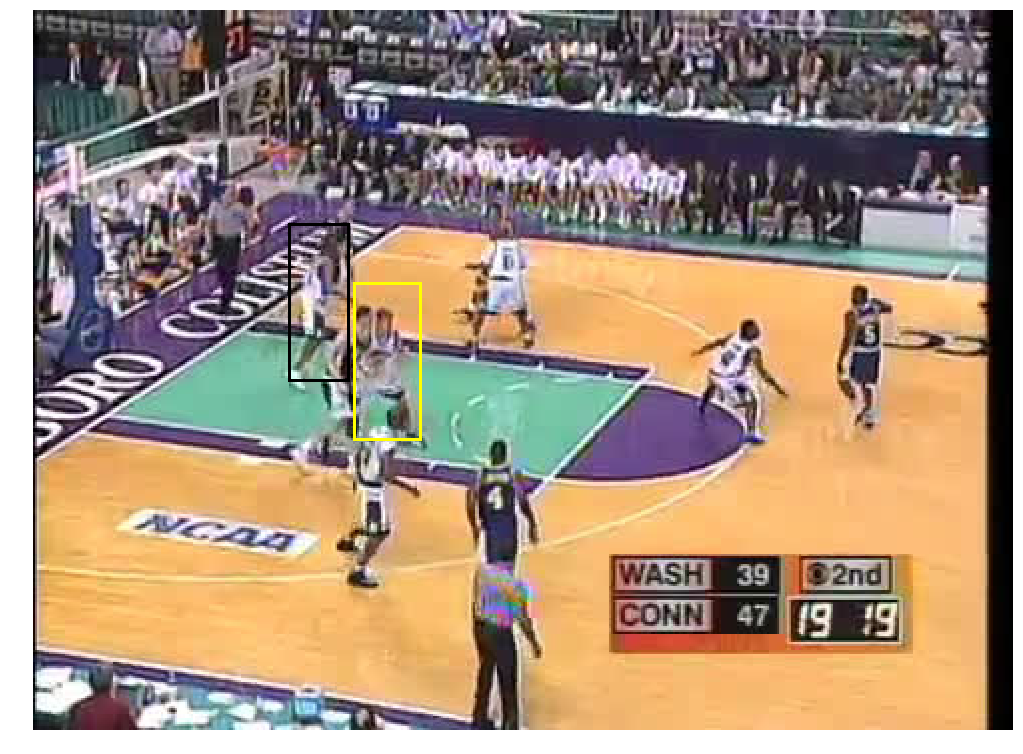

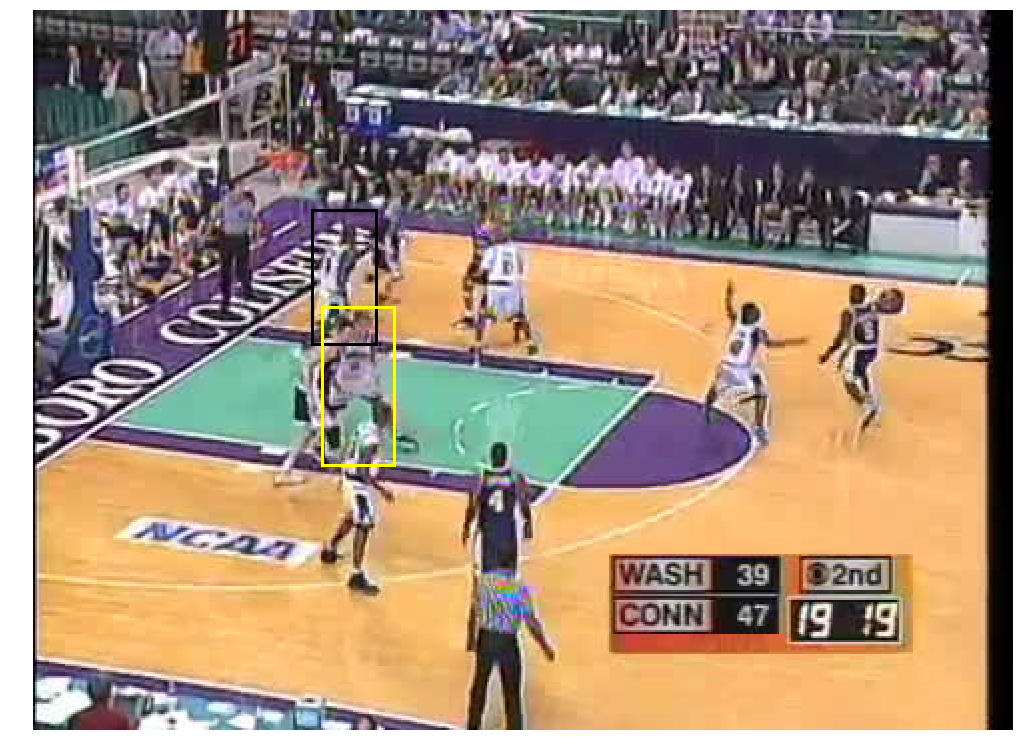

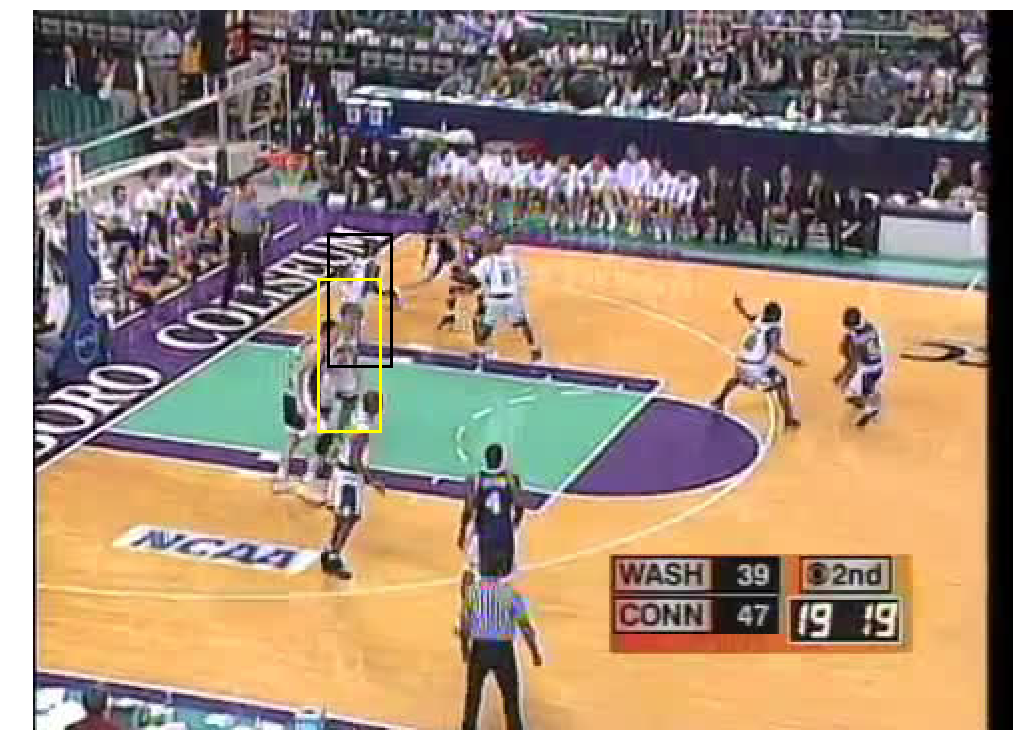

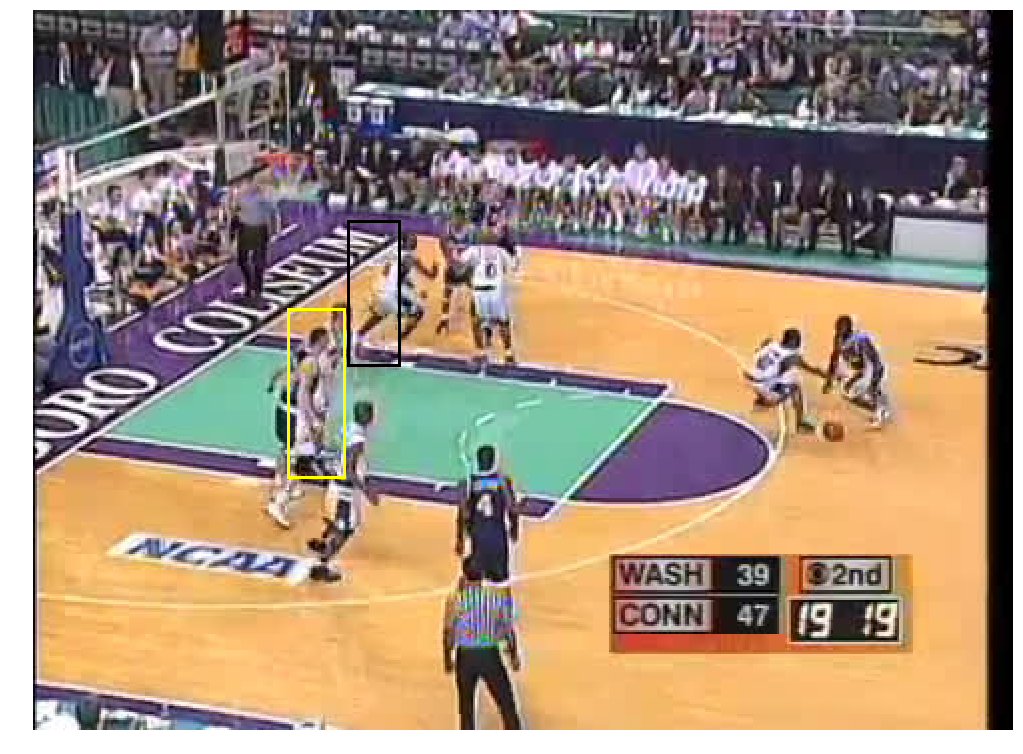

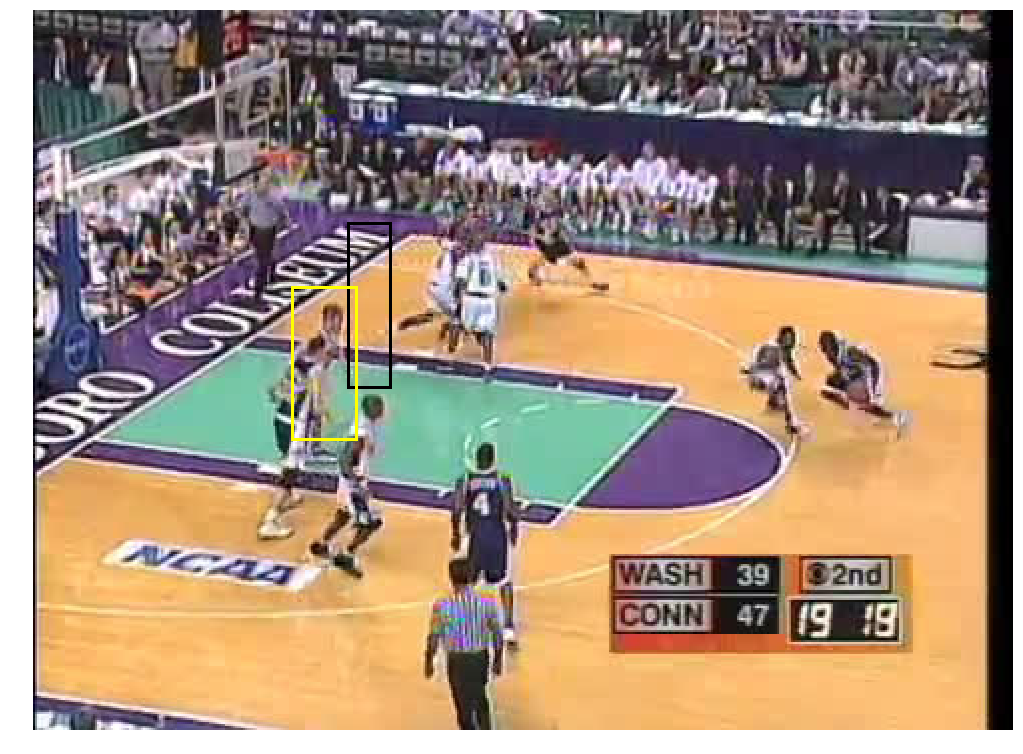

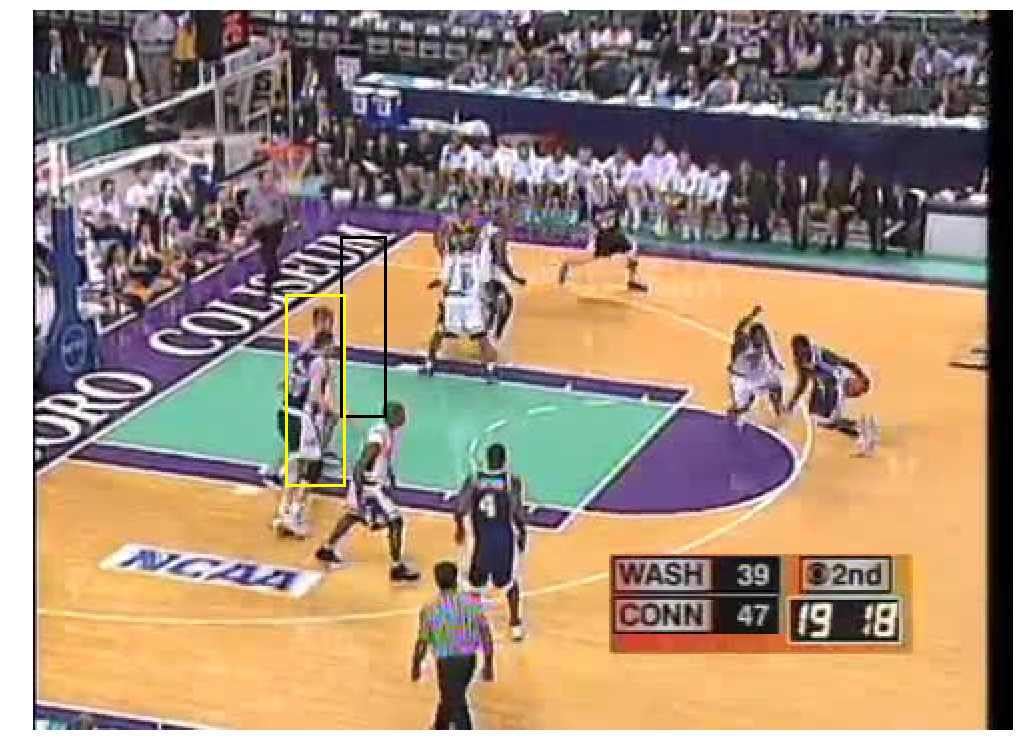

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


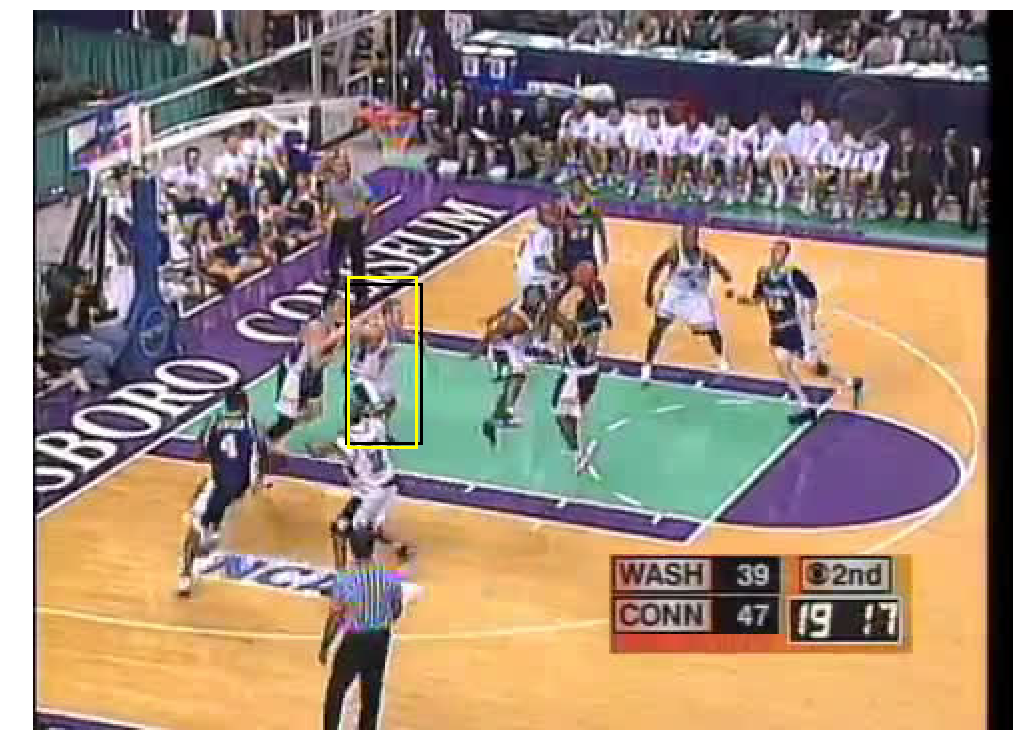

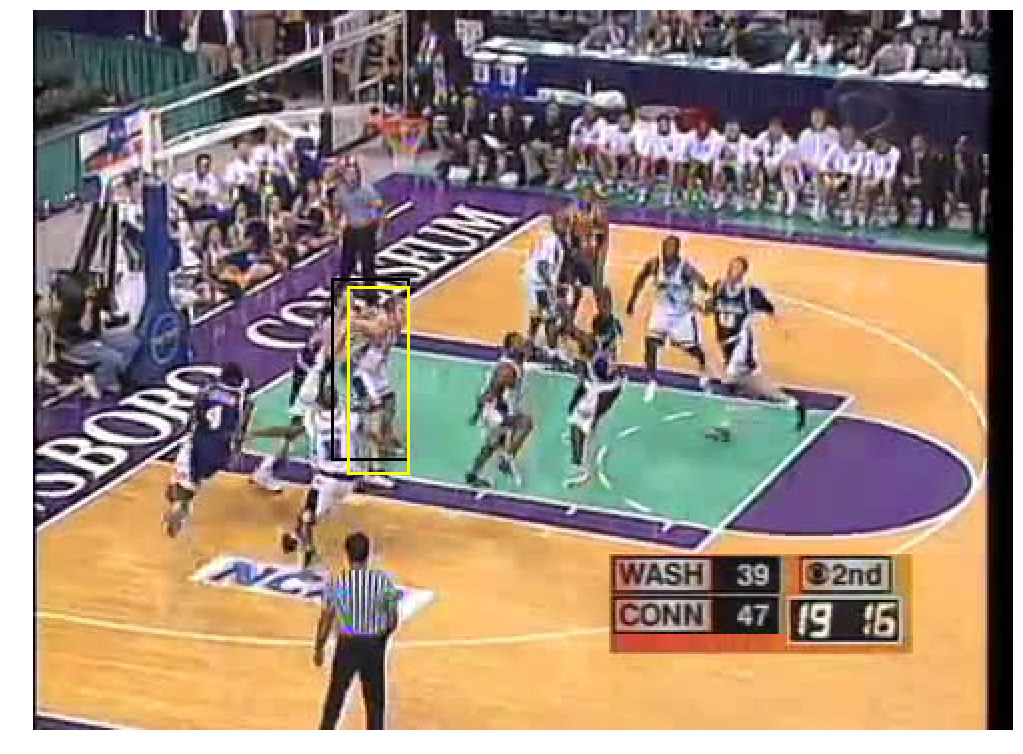

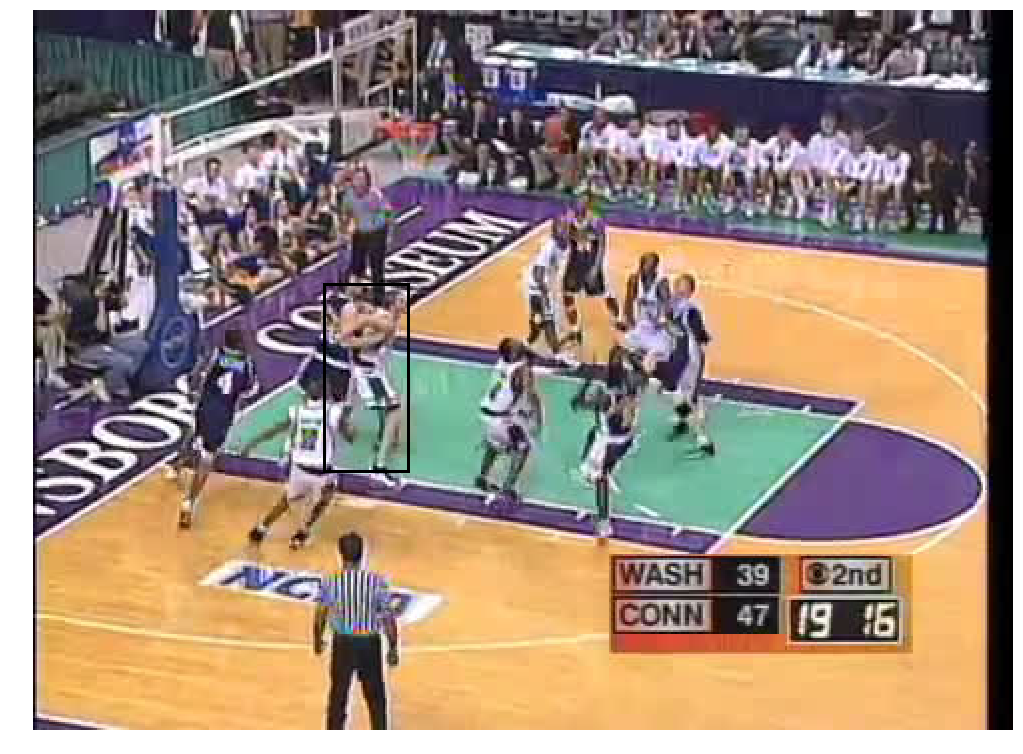

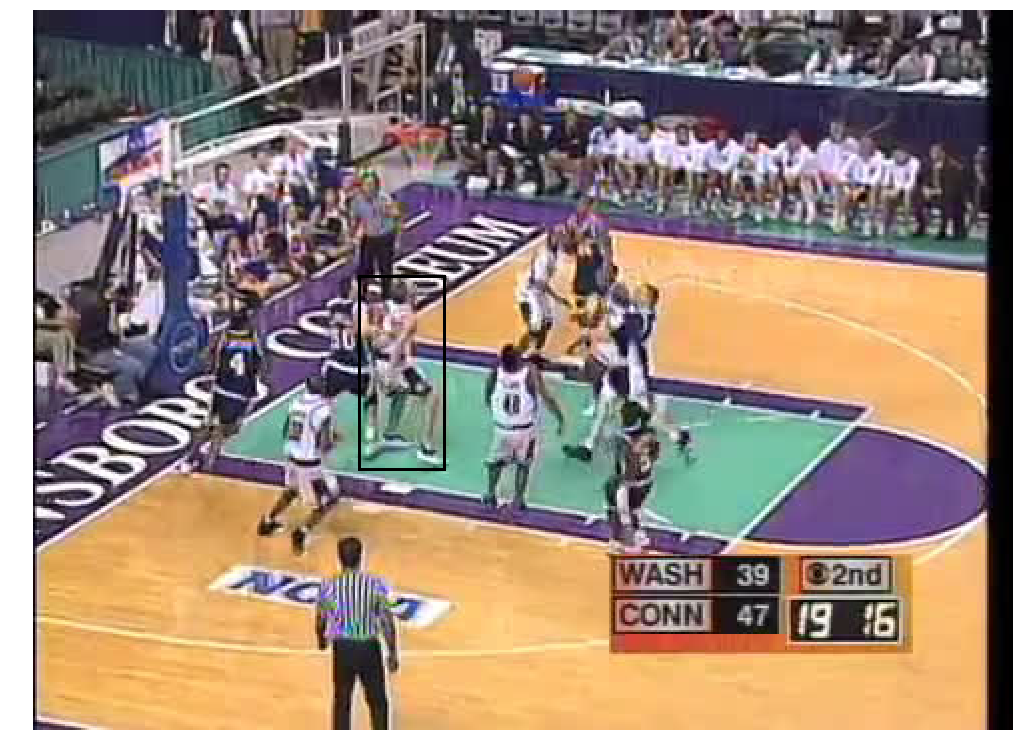

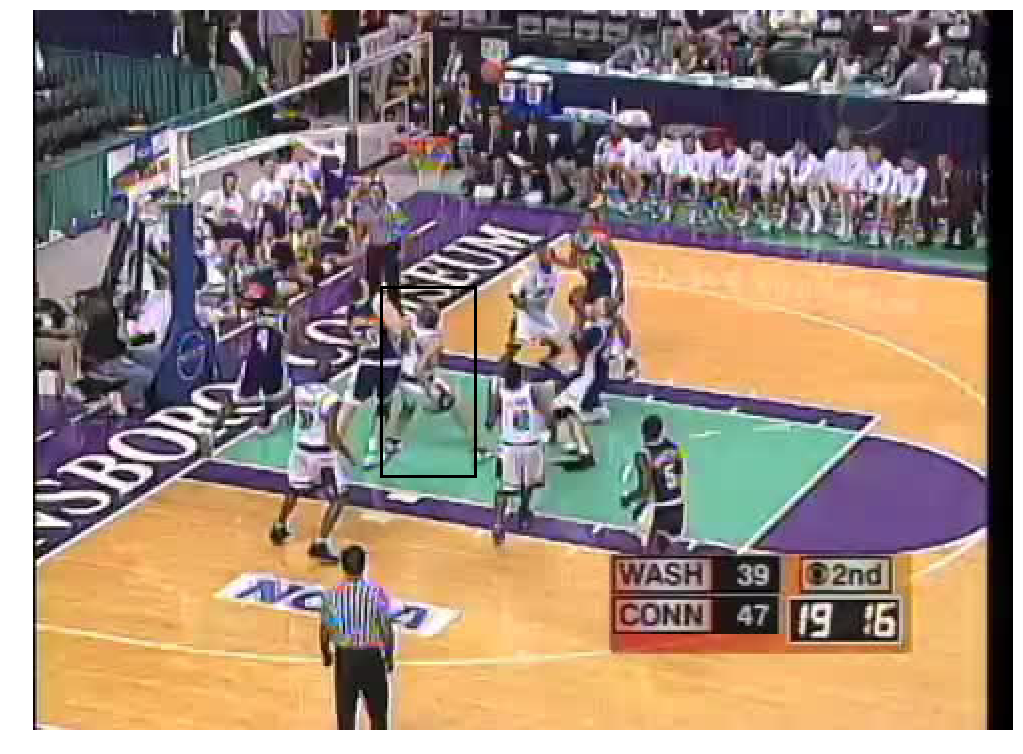

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [237]:
truth = df_list['person_25_02425022600']
csv_path = os.path.join(result_dir, result_csvs[3])
track = pd.read_csv(csv_path)
iou_list = run_files(images, image_dir, truth, track, True)
get_data(iou_list)